## Timeseries Forecasting with Prophet
In this notebook we'll go through an end to end example of training and deploying a timeseries model using the fbprophet libarary

In [1]:
%%capture
!pip3 install pystan==2.18
!pip install fbprophet

## Setup and Imports

In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO, StringIO
import pandas as pd
from itertools import starmap
from datetime import datetime
import sagemaker

from fbprophet import Prophet

In [3]:
# setup sagemaker variables
role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
bucket = sess.default_bucket()
key_prefix = "air-quality-prophet/{}"

## Data preparation

We'll use the Beijing Multi-Site Air-Quality Data Data Set hosted by UCI. The data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. For this example we'll take data from a single site and build a model to predict the amount of PM2.5 (fine particulates) in the air on a given day

In [4]:
# download air quality time-series data from UCI
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip"
zip_file = ZipFile(BytesIO(requests.get(data_url).content))
data = StringIO(zip_file.read("PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv").decode("utf8"))

df = pd.read_csv(data)
# convert to datetime index
df.index = df.apply(lambda x: datetime(x.year, x.month, x.day, x.hour), axis=1)

## Training Locally

Let's run a quick example locally to see how easy it is to train a timeseries model with fbprophet. The official Prophet site provides **[documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)** for fine-tuning the model

In [5]:
# resample to daily averages; split into train/test sets and only include the PM2.5 variables
train = df.loc[df["year"] < 2016, "PM2.5"].resample("1D").mean().reset_index().rename(columns={"index":"ds", "PM2.5":"y"})
test = df.loc[df["year"] >= 2016, "PM2.5"].resample("1D").mean().reset_index().rename(columns={"index":"ds", "PM2.5":"y"})

train.fillna(method="ffill", inplace=True)
test.fillna(method="ffill", inplace=True)

In [6]:
# train locally
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


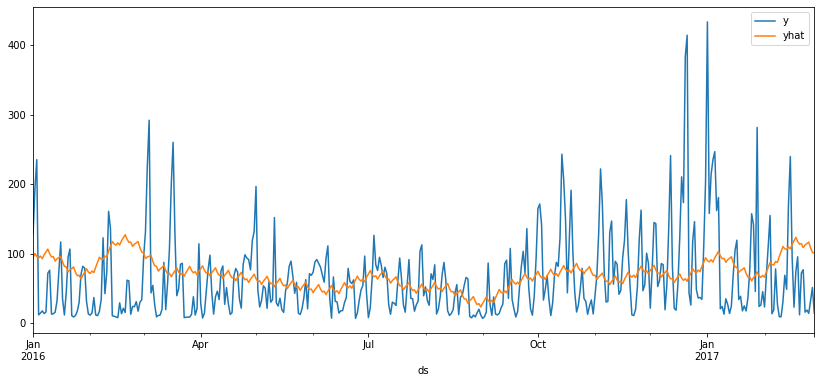

In [7]:
# make predictions and compare against test data
future = m.make_future_dataframe(periods=test.shape[0], include_history=False)
forecast = m.predict(future)

ax = test.set_index("ds").plot(figsize = (14,6))
forecast[["ds", "yhat"]].set_index("ds").plot(ax=ax)

## Training Remotely

To train the model remotely we need to do several things:
1. Upload our data to S3
2. Convert the notebook code above into a training script
3. Create a requirements.txt file to include additional dependencies (e.g. fbprophet) that are not present in the SKLearn container
4. Use the SageMaker SDK to configure and run a managed training job

In [8]:
# upload data to S3
for name, data_set in zip(["train","test"],[train, test]):
    sess.upload_string_as_file_body(body=data_set.to_csv(index=False),
                                   bucket=bucket,
                                   key=key_prefix.format(f"{name}.csv"))

In [9]:
# the notebook traing code above needs to be converted into a training script
# conviniently this training job will also generate predictions and save the results to S3
!pygmentize src/train.py | cat -n

     1	import argparse
     2	import os
     3	import pandas as pd
     4	import joblib
     5	from fbprophet import Prophet
     6	from glob import glob
     7	
     8	
     9	def train(data):
    10	    model = Prophet(growth=args.growth,
    11	               changepoints=args.changepoints,
    12	               n_changepoints=args.n_changepoints,
    13	               changepoint_prior_scale=args.changepoint_prior_scale)
    14	    
    15	    model.fit(data)
    16	    return model
    17	
    18	def predict(model):
    19	    
    20	    future = model.make_future_dataframe(periods=args.prediction_periods, include_history=False)
    21	    forecast = model.predict(future)
    22	    
    23	    return forecast
    24	    
    25	
    26	
    27	if __name__ =="__main__":
    28	
    29	    parser = argparse.ArgumentParser()
    30	
    31	    # hyperparameters sent by the client are passed as command-line arguments to the script.
    32	    parser.add_argument("--growth", type=str

In [10]:
%%capture
# setup a SageMaker training job (review tarin.py script in src directory)
from sagemaker.sklearn.estimator import SKLearn

prophet_estimator = SKLearn(source_dir="src",
                            entry_point="train.py",
                            framework_version="0.23-1",
                            hyperparameters = {"changepoint_prior_scale": 0.005, 
                                               "prediction_periods": 425},
                            train_instance_type="local", # will spin up a training container on the local notebook instance instead of launching a new virtual machine.
                            role=role)

train_data_path = f"s3://{bucket}/{key_prefix.format('train.csv')}"

prophet_estimator.fit({"train":train_data_path})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2020-09-21-14-12-12-696
INFO:sagemaker.local.local_session:Starting training job
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-bxn75:
    command: train
    environment:
    - AWS_REGION=us-east-1
    - TRAINING_JOB_NAME=sagemaker-scikit-learn-2020-09-21-14-12-12-696
    image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3
    networks:
      sagemaker-local:
        aliases:
        - algo-1-bxn75
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpuipm1dtg/algo-1-bxn75/output:/opt/ml/output
    - /tmp/tmpuipm1dtg/algo-1-bxn75/input:/opt/ml/input
    - /tmp/tmpuipm1dtg/algo-1-bxn75/output/data:/opt/ml/output/data
    - /tmp/tmpuipm1dtg/model:/opt/ml/model
    - /tmp/tmpx0wcvy

## Model Serving

Serving a timeseries model is not quite the same as serving an xgboost model. In XGBoost and SKLearn examples, we sent or model a record and it returned a prediction (i.e. a one to one mapping between input records and predictions returned). With timeseries forecasting though this may not be the case and depending on the usecase we may have any number of ways of serving predictions such as:
- **Input**: a list of dates; **Output**: forecast for the dates provided
- **Input**: starting date and number of periods forward; **Output**: Forward forecast for the period specified
- **Input**: start and end date; **Output**: forecast for each date between start and end
With SageMaker you can pass in a serving script to customize how inputs tor your model are processed and how the outputs of your model are post-processed before returning the results to the user. In this example we'll provide a serving script that will take a json input like this:
```
    {
        "start": "1/1/2016",
        "end": "2/28/2017"
    }
```
And will return a list of predictions for each date that falls within the specified start-end period:
```
    [
        {"ds":1/1/2016, "yhat_lower": 5,"yhat_upper": 20, "yhat": 12},
        ...
    ]
```

In [11]:
# prepare a serving script to host the model as a rest api endpoint
!pygmentize src/serve.py | cat -n

     1	import joblib
     2	import os
     3	import json
     4	import pandas as pd
     5	
     6	
     7	def model_fn(model_dir):
     8	    """loads model from previously saved artifact"""
     9	    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    10	    return model
    11	
    12	def input_fn(request_body, request_content_type):
    13	    
    14	    """handles input received from the API endpoint
    15	    In this case input is expected in this format:
    16	    {
    17	        "start": "1/1/2016",
    18	        "end": "2/28/2017"
    19	    }
    20	    Where start and end represent the peirod for which we wish the model to provide a forecast
    21	    """
    22	    
    23	    request = json.loads(request_body.decode("utf8"))
    24	
    25	    future = pd.DataFrame(pd.date_range(start=request["start"], 
    26	                                        end=request["end"], 
    27	                                        freq="D"), 
    28	                  

In [12]:
%%capture
# deploy as a REST Endpoint 
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.predictor import json_serializer, json_deserializer

prophet_model = SKLearnModel(source_dir="src",
                         entry_point="serve.py",
                         framework_version="0.23-1",
                         model_data = prophet_estimator.model_data,
                         role = role
                    )

predictor = prophet_model.deploy(instance_type="local", 
                initial_instance_count=1)

predictor.serializer = json_serializer # convert python dict input to json 
predictor.deserializer = json_deserializer # converts binary encoded json string output to python dictionary

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2020-09-21-14-20-07-366
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2020-09-21-14-20-07-366
INFO:sagemaker.local.image:serving
INFO:sagemaker.local.image:creating hosting dir in /tmp/tmpm2r5gp_s
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-r4bri:
    command: serve
    environment:
    - SAGEMAKER_PROGRAM=serve.py
    - SAGEMAKER_SUBMIT_DIRECTORY=s3://sagemaker-us-east-1-152804913371/sagemaker-scikit-learn-2020-09-21-14-20-06-148/sourcedir.tar.gz
    - SAGEMAKER_ENABLE_CLOUDWATCH_METRICS=false
    - SAGEMAKER_CONTAINER_LOG_LEVEL=20
    - SAGEMAKER_REGION=us-east-1
    image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3
    networks:
      sagemaker-local:
        aliase

In [13]:
# let's ge predictions from our newly deployed endpoint
predictions = predictor.predict({"start": "1-1-2016", "end": "2-28-2017"})

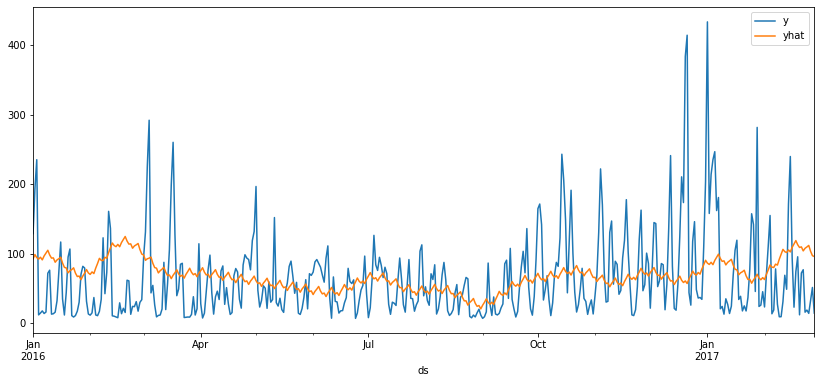

In [14]:
# convert predictions to a dataframe and visualize
predictions_df = pd.DataFrame(predictions)
predictions_df["ds"] = pd.to_datetime(predictions_df["ds"])

ax = test.set_index("ds").plot(figsize = (14,6))
predictions_df[["ds", "yhat"]].set_index("ds").plot(ax=ax)

In [15]:
# delete endpoint
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-scikit-learn-2020-09-21-14-20-07-366
INFO:sagemaker:Deleting endpoint with name: sagemaker-scikit-learn-2020-09-21-14-20-07-366


## Hyperparameter optimization

Finally SageMaker provides a HyperparameterTuner which allows you to run multiple concurrent jobs to find the best set pf hyperparameters

In [ ]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner

In [ ]:
# create a base training job
prophet_estimator_hpo = SKLearn(source_dir="src",
                            entry_point="train-hpo.py",
                            framework_version="0.23-1",
                            train_instance_type="ml.m5.large",
                            role=role)

In [ ]:
# provide hyperparam ranges for grid search
hyperparameter_ranges = {'changepoint_prior_scale': ContinuousParameter(0.001, 0.5),
                        'seasonality_prior_scale': ContinuousParameter(0.01, 5),
                        'seasonality_mode': CategoricalParameter(['additive', 'multiplicative'])
                        }

In [ ]:
# create and traom a HyperparameterTuner object
tuner = HyperparameterTuner(estimator=prophet_estimator_hpo, 
                            objective_metric_name="rmse", 
                            metric_definitions=[{"Name":"rmse", "Regex":"train rmse: (\S+)"}], # SageMaker will parse the target metric from the logs
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=20, 
                            max_parallel_jobs=5,
                            objective_type='Minimize'
                       )

tuner.fit({"train":train_data_path})

In [ ]:
# view details of tuning job
sess.describe_tuning_job(tuner.latest_tuning_job.job_name)

In [ ]:
# query the best model and deploy it
best_job = sess.describe_tuning_job(tuner.latest_tuning_job.job_name)["BestTrainingJob"]["TrainingJobName"]
best_model = sess.describe_training_job(best_job)['ModelArtifacts']['S3ModelArtifacts']

prophet_model = SKLearnModel(source_dir="src",
                         entry_point="serve.py",
                         framework_version="0.23-1",
                         model_data = best_model,
                         role = role
                    )

predictor = prophet_model.deploy(instance_type="local", 
                initial_instance_count=1)

predictor.serializer = json_serializer # convert python dict input to json 
predictor.deserializer = json_deserializer # converts binary encoded json string output to python dictionary

In [ ]:
predictions = predictor.predict({"start": "1-1-2016", "end": "2-28-2017"})
predictions_df = pd.DataFrame(predictions)
predictions_df["ds"] = pd.to_datetime(predictions_df["ds"])
ax = test.set_index("ds").plot(figsize = (14,6))
predictions_df[["ds", "yhat"]].set_index("ds").plot(ax=ax)

In [ ]:
predictor.delete_endpoint()